In [1]:
import gpn.model
from gpn.data import GenomeMSA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.stats import entropy
import seaborn as sns
import torch
from transformers import AutoModel

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# keep in mind RoFormer inductive bias to favour local attention

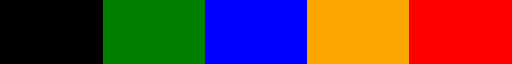

In [55]:
vocab = list("-ACGT")
cmap = ListedColormap([[0, 0, 0], [0, .5, 0], [0, 0, 1], [1, .65, 0], [1, 0, 0]])
cmap

In [2]:
model_path = "songlab/gpn-msa-sapiens"
model = AutoModel.from_pretrained(model_path)
model.eval();

Some weights of the model checkpoint at songlab/gpn-msa-sapiens were not used when initializing GPNRoFormerModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing GPNRoFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPNRoFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")

In [287]:
# TODO: add a TFBS
chrom, start, end = "12", 4275613, 4275741  # ncRNA, interesting
#chrom, start, end = "X", 15570261, 15570389  # exon with intron flank, interesting
#chrom, start, end = "X", 15570431, 15570559  # intron
#chrom, start, end = "X", 15602172, 15602300  # ACE2 promoter region, highly conserved
#chrom, start, end = "7", 27094489, 27094617  # hox gene CDS
print(end-start)

128


In [288]:
msa = genome_msa.get_msa(chrom, start, end, tokenize=True)
input_ids, aux_features = msa[:, 0], msa[:, 1:]
input_ids = input_ids.astype(np.int64)
input_ids.shape, aux_features.shape

((128,), (128, 89))

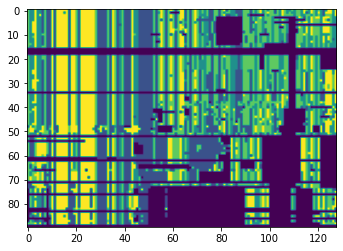

In [289]:
# maybe don't tokenize yet?
plt.imshow(msa.T)

In [290]:
with torch.no_grad():
    attentions = model(
        input_ids=torch.tensor(input_ids).unsqueeze(0),
        aux_features=torch.tensor(aux_features).unsqueeze(0),
        output_attentions=True
    ).attentions
    attentions = np.array([a[0].squeeze().numpy() for a in attentions])
attentions.shape  # layer, head, from, to

(12, 12, 128, 128)

In [291]:
n_layers, n_heads, L, _ = attentions.shape

In [292]:
raise Exception("unupdated. was for a single layer")

data = msa.T
# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(8,4), height_ratios=[2,1])

im = axs[0].imshow(data, interpolation='none', cmap=cmap,  aspect='auto')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=vocab[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
axs[0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_ylabel("Species");


# mean attention_to
#mean_attention_to = attentions.mean(axis=(0, 1))
#axs[1].plot(mean_attention_to)
#axs[1].set_ylabel("Mean attention");


# entropy in the "attention_to"
uniform_entropy = entropy(np.ones(msa.shape[0]), base=2)
mean_entropy = entropy(attentions, axis=2, base=2).mean(axis=0)
axs[1].plot(mean_entropy)
axs[1].axhline(uniform_entropy, color="black", linestyle="--", alpha=0.5)
axs[1].set_ylabel("Mean attention entropy");

plt.xlabel("Genomic position")
plt.grid(False)
sns.despine();

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_29086/3924405058.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_29086/3924405058.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: unupdated. was for a single layer

Text(0, 0.5, 'Mean attention to')

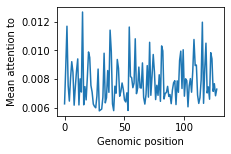

In [293]:
mean_attention_to = attentions.mean(axis=(0,1,2))
plt.figure(figsize=(3,2))
plt.plot(mean_attention_to)
plt.xlabel("Genomic position");
plt.ylabel("Mean attention to")

In [294]:
chrom, start + np.argmax(mean_attention_to)

('12', 4275628)

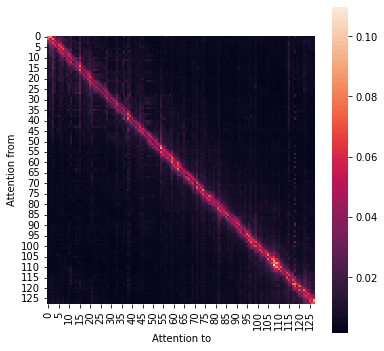

In [295]:
# average over both layers and heads
mean_attention = attentions.mean(axis=(0,1))
plt.figure(figsize=(6,6))
sns.heatmap(mean_attention, square=True)
plt.ylabel("Attention from")
plt.xlabel("Attention to");

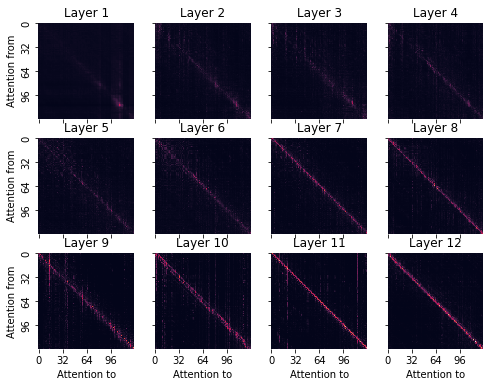

In [296]:
mean_attention_per_layer = attentions.mean(axis=1)  # average over heads
vmin, vmax = mean_attention_per_layer.min(), mean_attention_per_layer.max()

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(8,6))

for i in range(n_layers):
    ax = axs.flatten()[i]
    sns.heatmap(mean_attention_per_layer[i], square=True, vmin=vmin, vmax=vmax, ax=ax, cbar=False, xticklabels=32, yticklabels=32)
    ax.set_title(f"Layer {i+1}")
    
# Set xlabel for the bottom subplots
for ax in axs[-1]:
    ax.set_xlabel("Attention to")

# Set ylabel for the left subplots
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel("Attention from")

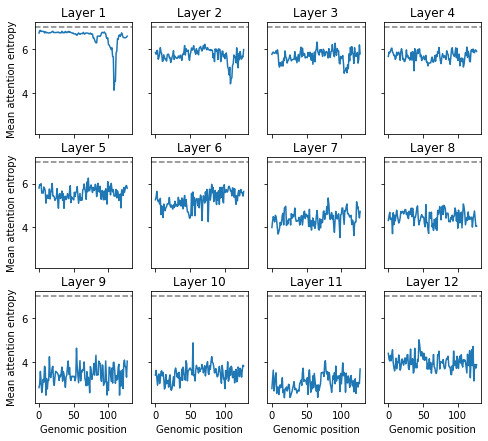

In [297]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(8,7))
uniform_entropy = entropy(np.ones(L), base=2)

for i in range(n_layers):
    ax = axs.flatten()[i]
    ax.plot(entropy(attentions[i], axis=2, base=2).mean(axis=0))
    ax.axhline(uniform_entropy, color="black", linestyle="--", alpha=0.5)
    ax.set_title(f"Layer {i+1}")

# Set xlabel for the bottom subplots
for ax in axs[-1]:
    ax.set_xlabel("Genomic position")

# Set ylabel for the left subplots
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel("Mean attention entropy")